In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import time
import os
import math
from IPython.display import display, clear_output
import helpfunction as helper

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

In [4]:
gr = (1 + 5 ** 0.5) / 2
outdir = "./output/"
main_tree_name = "NuCCanalyzer"
title_mc_str = r"$\nu_\mu$ CC Filter, MicroBooNE INTERNAL"

<IPython.core.display.Javascript object>

In [5]:
fidvol_vtx = [10, 10, 10, 10, 10, 50]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]

mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

tot_pot = 13.2e20

<IPython.core.display.Javascript object>

In [6]:
file_name = "./input/run1/nucc_nue_overlay_run1_mcc9.root"
file = uproot.open(file_name)[main_tree_name]

<IPython.core.display.Javascript object>

In [7]:
print("-- Delta NC radiative --")
file_name_dnc = "./input/run1/nucc_ncdelta_overlay_run1_mcc9.root"
dnc_events = uproot.open(file_name_dnc)[main_tree_name]["Event"]
dnc_subruns = uproot.open(file_name_dnc)[main_tree_name]["subruns"]

dnc_pot = sum(dnc_subruns.array("pot"))
scale_pot = dnc_pot / tot_pot
tot_events_weighted = sum(dnc_events.array("event_weight"))
sel_weighted = sum(
    dnc_events.array("nu_mu_cc_selected") * dnc_events.array("event_weight")
)

print("events: {:0.0f}".format(tot_events_weighted))
print("pot: {:0.3g}".format(dnc_pot))
print(
    "selected: {:0.1f}, passing fraction: {:0.2f}%".format(
        sel_weighted, sel_weighted / tot_events_weighted * 100
    )
)
print("selected per {:0.3g}: {:0.1f}".format(tot_pot, sel_weighted / scale_pot))

-- Delta NC radiative --
events: 93120
pot: 4.36e+23
selected: 2058.0, passing fraction: 2.21%
selected per 1.32e+21: 6.2


<IPython.core.display.Javascript object>

In [8]:
muon_candidate_selection = "track_score>0.85 &\
                            vtx_distance<4.0 &\
                            track_chi2_proton>60.0 &\
                            track_chi2_muon<30.0 &\
                            (track_chi2_proton/track_chi2_muon)>7.0 &\
                            generation==2 &\
                            track_length>5"

event_selection = "nu_pdg==14 &\
                   (nu_flash_chi2<10.0 | nu_score>0.25) &\
                   daughters_start_contained &\
                   nu_contained &\
                   longest_muon_candidate_length==track_length &\
                   nu_score>0.06 &\
                   (nu_flash_chi2/obvious_cosmic_chi2)<5.0"

<IPython.core.display.Javascript object>

In [9]:
nue = {}
nue["subruns"] = file["subruns"]
nue["events"] = file["Event"]
nue["daughters"] = file["Daughters"]

<IPython.core.display.Javascript object>

In [10]:
# check for duplicates
event_hash = helper.eventHash(
    nue["events"].pandas.df(["evt_time_sec", "evt_time_nsec"])
)
forbidden_hashes = event_hash[event_hash.duplicated()]
print(len(forbidden_hashes))

10109


<IPython.core.display.Javascript object>

In [11]:
# Passing fraction nue without requiring the energy cuts!
print("-- All Intrinsic Nues --")
nue_pot = sum(nue["subruns"].array("pot"))
nue_pot_corr = sum(nue["subruns"].array("pot")) * (
    1 - len(forbidden_hashes) * 2 / nue["events"].numentries
)
scale_pot = nue_pot / tot_pot
scale_pot_corr = nue_pot_corr / tot_pot

tot_events_weighted = sum(nue["events"].array("event_weight"))
sel_weighted = sum(
    nue["events"].array("nu_mu_cc_selected") * nue["events"].array("event_weight")
)
sid_weighted = sum(
    (nue["events"].array("hitsSps") > 0) * nue["events"].array("event_weight")
)

print("events: {:0.0f}".format(tot_events_weighted))
print("pot: {:0.3g}".format(nue_pot))
print(
    "selected (SliceID): {:0.1f}, passing fraction: {:0.2f}%".format(
        sid_weighted, sid_weighted / tot_events_weighted * 100
    )
)
print(
    "selected (NuMuCC): {:0.1f}, passing fraction: {:0.2f}%".format(
        sel_weighted, sel_weighted / tot_events_weighted * 100
    )
)
print("selected per {:0.3g}: {:0.1f}".format(tot_pot, sel_weighted / scale_pot))

-- All Intrinsic Nues --
events: 217923
pot: 1.27e+23
selected (SliceID): 173701.8, passing fraction: 79.71%
selected (NuMuCC): 9241.6, passing fraction: 4.24%
selected per 1.32e+21: 96.1


<IPython.core.display.Javascript object>

In [12]:
df_daughters = nue["daughters"].pandas.df()
df_daughters["hash"] = helper.eventHash(df_daughters[["evt_time_sec", "evt_time_nsec"]])
df_daughters["duplicated"] = df_daughters["hash"].isin(forbidden_hashes)
df_daughters = df_daughters.query("~duplicated").copy()

<IPython.core.display.Javascript object>

In [13]:
print([str(k.decode()) for k in nue["subruns"].keys()], "\n\n")
print([str(k.decode()) for k in nue["events"].keys()], "\n\n")
print([str(k.decode()) for k in nue["daughters"].keys()], "\n\n")

['run', 'subRun', 'pot'] 


['event', 'run', 'subrun', 'event_weight', 'evt_time_sec', 'evt_time_nsec', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'total_hits', 'caloU', 'caloV', 'caloY', 'hitsSps', 'num_primary_daughters', 'num_daughters', 'num_showers', 'num_tracks', 'daughters_stored', 'nu_vx', 'nu_vy', 'nu_vz', 'nu_contained', 'daughters_start_contained', 'nu_pdg', 'nu_score', 'nu_flash_chi2', 'obvious_cosmic_chi2', 'nu_mu_cc_selected', 'num_neutrinos', 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_vx_sce', 'mc_nu_vy_sce', 'mc_nu_vz_sce', 'mc_nu_energy', 'mc_nu_px', 'mc_nu_py', 'mc_nu_pz', 'mc_nu_lepton_energy', 'mc_nu_lepton_px', 'mc_nu_lepton_py', 'mc_nu_lepton_pz', 'mc_nu_lepton_theta', 'mc_nu_time', 'mc_nu_pdg', 'mc_nu_interaction_type', 'mc_nu_target', 'mc_nu_hitnuc', 'mc_nu_hitquark', 'mc_nu_w', 'mc_nu_x', 'mc_nu_y', 'mc_nu_qsqr', 'mc_nu_ccnc', 'mc_nu_vtx_distance', 'num_matched_daughters', 'cosmic_matched', 'clustered_hit_completeness', 'matched_hit_fraction', 'mc_nu_daughter_matched

<IPython.core.display.Javascript object>

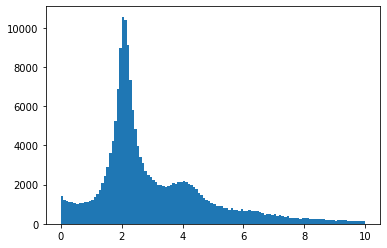

<IPython.core.display.Javascript object>

In [14]:
dedx_mask = nue["daughters"].array("start_hitsY") > 3
_ = plt.hist(nue["daughters"].array("start_dedxY")[dedx_mask], range=(0, 10), bins=120)

### Add fields to daughters frame

In [15]:
cols = [
    "evt_time_sec",
    "evt_time_nsec",
    "nu_mu_cc_selected",
    "mc_nu_interaction_type",
    "mc_nu_ccnc",
    "mc_nu_energy",
    "mc_nu_lepton_energy",
    "mc_nu_lepton_theta",
    "mc_nu_pdg",
    "mc_nu_vx",
    "mc_nu_vy",
    "mc_nu_vz",
    "event_weight",
]

df_nu_event = nue["events"].pandas.df(cols)

nu_fid_vol_mask = helper.inTPC_mask(
    df_nu_event, "mc_nu_vx", "mc_nu_vy", "mc_nu_vz", fidvol=fidvol_vtx
)

signal_def_string = "1.5>mc_nu_energy>0.05 & mc_nu_ccnc==0 & mc_nu_pdg==12"
nu_sig_mask = df_nu_event.eval(signal_def_string)

# Add MC info
mapper = dict(zip(event_hash, nu_sig_mask))
df_daughters["mc_nu_cc_sig"] = df_daughters["hash"].map(mapper)
mapper = dict(zip(event_hash, nu_fid_vol_mask))
df_daughters["mc_nu_fid_vol"] = df_daughters["hash"].map(mapper)

<IPython.core.display.Javascript object>

In [16]:
mapper_list = {
    "nu_pdg",
    "num_tracks",
    "num_showers",
    "obvious_cosmic_chi2",
    "nu_flash_chi2",
    "nu_score",
    "nu_contained",
    "daughters_start_contained",
    "mc_nu_energy",
    "mc_nu_lepton_theta",
    "mc_nu_vtx_distance",
    "nu_mu_cc_selected",
    "event_weight",
    "clustered_hit_completeness",
    "matched_hit_fraction",
}

for field in mapper_list:
    mapper = dict(zip(event_hash, nue["events"].array(field)))
    df_daughters[field] = df_daughters["hash"].map(mapper)

<IPython.core.display.Javascript object>

### Selection

In [17]:
# Select Muon Candidate
df_daughters["muon_candidate"] = df_daughters.eval(muon_candidate_selection)
df_daughters.loc[df_daughters["muon_candidate"], "longest_muon_candidate_length"] = (
    df_daughters.query("muon_candidate")
    .groupby(["hash"])["track_length"]
    .transform(max)
)
df_daughters.loc[~df_daughters["muon_candidate"], "longest_muon_candidate_length"] = -1

<IPython.core.display.Javascript object>

In [18]:
# Select Muon Candidate alternative
df_daughters["chi2_ratio"] = df_daughters.eval("track_chi2_proton/track_chi2_muon")
df_daughters.loc[df_daughters["muon_candidate"], "highest_chi2_ratio"] = (
    df_daughters.query("muon_candidate").groupby(["hash"])["chi2_ratio"].transform(max)
)
df_daughters.loc[~df_daughters["muon_candidate"], "highest_chi2_ratio"] = -1

<IPython.core.display.Javascript object>

In [19]:
#### Selection queries
query_select_wo_trackcut = event_selection
query_select = query_select_wo_trackcut + " & track_length>10"

<IPython.core.display.Javascript object>

In [20]:
df_daughters["python_select"] = df_daughters.eval(query_select)

<IPython.core.display.Javascript object>

In [21]:
# Check if python and C++ agree

print(sum(df_daughters.query("mc_nu_cc_sig")["muon_candidate"]))
print(sum(df_daughters.query("mc_nu_cc_sig")["track_is_muon_candidate"]))
print(
    len(
        df_daughters.query("mc_nu_cc_sig").query(
            "muon_candidate | track_is_muon_candidate"
        )
    )
)

print(sum(df_daughters.query("mc_nu_cc_sig")["python_select"]))
print(
    len(df_daughters.query("mc_nu_cc_sig").query("nu_mu_cc_selected").groupby("hash"))
)

19733
19733
19733
4550
3819


<IPython.core.display.Javascript object>

In [22]:
# how much nue events pass
num_nue_pass = sum(
    df_daughters.query("mc_nu_cc_sig").query("python_select")["event_weight"]
)
num_nue_pass_err = np.sqrt(num_nue_pass)
print(
    "Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: {0:.2f}+/-{1:.2f} per {2:.3g}POT.".format(
        num_nue_pass / scale_pot_corr, num_nue_pass_err / scale_pot_corr, tot_pot
    )
)

Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: 53.34+/-0.78 per 1.32e+21POT.


<IPython.core.display.Javascript object>

In [23]:
# how much nue events pass (C++)
num_nue_pass = sum(
    df_daughters.query("mc_nu_cc_sig")
    .query("nu_mu_cc_selected")[["hash", "event_weight"]]
    .groupby("hash")
    .first()
    .values
)[0]

num_nue_pass_err = np.sqrt(num_nue_pass)
print(
    "Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: {0:.2f}+/-{1:.2f} per {2:.3g}POT.".format(
        num_nue_pass / scale_pot_corr, num_nue_pass_err / scale_pot_corr, tot_pot
    )
)

Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: 44.68+/-0.72 per 1.32e+21POT.


<IPython.core.display.Javascript object>

Take the selection as doen in the producer module!

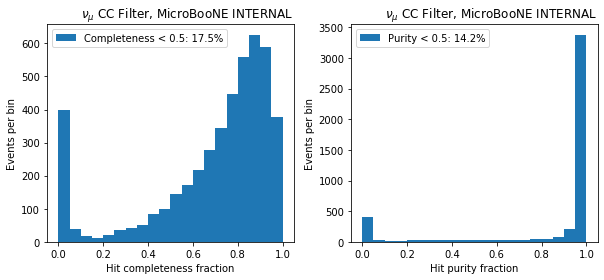

<IPython.core.display.Javascript object>

In [24]:
# is the muon candidate always matched?
# what is the purity completeness of the event
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8.5, 4), sharex=True)

sel_comp = df_daughters.query("mc_nu_cc_sig & python_select")[
    "clustered_hit_completeness"
]
sel_purity = df_daughters.query("mc_nu_cc_sig & python_select")["matched_hit_fraction"]

label = "Completeness < 0.5: {:0.1f}%".format(sum(sel_comp < 0.5) / len(sel_comp) * 100)
ax[0].hist(sel_comp, bins=20, label=label)
ax[0].set_xlabel("Hit completeness fraction")
ax[0].set_ylabel("Events per bin")
ax[0].legend()
ax[0].set_title(title_mc_str, loc="right")

label = "Purity < 0.5: {:0.1f}%".format(sum(sel_purity < 0.5) / len(sel_purity) * 100)
ax[1].hist(sel_purity, bins=20, label=label)
ax[1].set_xlabel("Hit purity fraction")
ax[1].set_ylabel("Events per bin")
ax[1].legend()
ax[1].set_title(title_mc_str, loc="right")

fig.tight_layout()
fig.savefig(outdir + "pur_comp_nue_passing.pdf")

In [25]:
reco_quality_str = "(clustered_hit_completeness< 0.5 | matched_hit_fraction<0.5)"
sig_sel_str = "mc_nu_cc_sig & python_select"

# Denominator
num_all_sum = sum(df_daughters.query(sig_sel_str)["event_weight"])
num_all_E = df_daughters.query(sig_sel_str)["mc_nu_energy"]

# Bad reconstructed
num_bad_reco_sum = sum(
    df_daughters.query(reco_quality_str).query(sig_sel_str)["event_weight"]
)


num_bad_reco_E = df_daughters.query(reco_quality_str).query(sig_sel_str)["mc_nu_energy"]
# Matched wrong pdg
num_pdg_sum = []
num_pdg_E = []
for pdg in [11, 211, 2212]:
    temp = (
        df_daughters.query("~" + reco_quality_str)
        .query("abs(mc_pdg)==@pdg")
        .query(sig_sel_str)["event_weight"]
        .sum()
    )
    num_pdg_sum.append(temp)
    temp = (
        df_daughters.query("~" + reco_quality_str)
        .query("abs(mc_pdg)==@pdg")
        .query(sig_sel_str)["mc_nu_energy"]
    )
    num_pdg_E.append(temp)

<IPython.core.display.Javascript object>

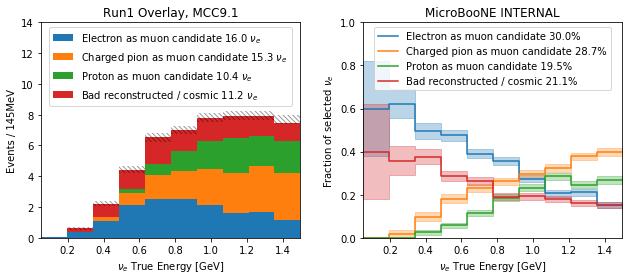

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 4), sharex=True)

N = 10
x_min = 0.05
x_max = 1.5

data_sum = [*num_pdg_sum, num_bad_reco_sum, num_all_sum]
data = [*num_pdg_E, num_bad_reco_E, num_all_E]

edges, edges_mid, bins, err, max_val = helper.histHelper(
    N, x_min, x_max, data, weights=[1 / scale_pot_corr] * 5
)

widths = edges[1:] - edges[:-1]

labels = [
    "Electron as muon candidate",
    "Charged pion as muon candidate",
    "Proton as muon candidate",
    "Bad reconstructed / cosmic",
]

lower = np.zeros(N)
for i in range(4):
    ax[0].bar(
        edges_mid,
        bins[i],
        lw=2,
        width=widths,
        label=labels[i] + r" {:.1f} $\nu_e$".format(data_sum[i] / scale_pot_corr),
        bottom=lower,
    )
    lower += bins[i]

for m, v, e, w in zip(edges_mid, bins[-1], err[-1], widths):
    ax[0].add_patch(
        patches.Rectangle(
            (m - w / 2, v - e),
            w,
            2 * e,
            hatch="\\\\\\\\\\",
            Fill=False,
            linewidth=0,
            alpha=0.4,
        )
    )
ax[0].set_xlabel(r"$\nu_e$ True Energy [GeV]")
ax[0].set_ylabel(r"Events / 145MeV")
ax[0].set_ylim(0, 14)
ax[0].legend(loc="upper center")
ax[0].set_title("Run1 Overlay, MCC9.1")


_, _, bins, _, _ = helper.histHelper(N, x_min, x_max, data)
for i in range(4):
    fraq = bins[i] / bins[-1]
    ratio = data_sum[i] / data_sum[-1]
    err = np.sqrt(fraq * (1 - fraq) / bins[-1])
    fraq = np.append(fraq, fraq[-1])
    err = np.append(err, err[-1])

    ax[1].step(
        edges,
        fraq,
        color="C" + str(i),
        where="post",
        label=labels[i] + r" {:.1f}%".format(ratio * 100),
    )
    ax[1].fill_between(
        edges, fraq - err, fraq + err, alpha=0.3, step="post", color="C" + str(i)
    )

ax[1].set_xlim(x_min, x_max)
ax[1].set_ylabel(r"Fraction of selected $\nu_e$")
ax[1].set_xlabel(r"$\nu_e$ True Energy [GeV]")
ax[1].set_ylim(0, 1)
ax[1].set_title("MicroBooNE INTERNAL")
ax[1].legend(loc="upper center")

fig.tight_layout()
fig.savefig(outdir + "unblinding_nue_reasons.pdf")

In [27]:
abs(
    df_daughters.query("mc_nu_cc_sig").query(query_select)["mc_pdg"]
).value_counts() / len(df_daughters.query("mc_nu_cc_sig").query(query_select)) * 100

11      38.043956
211     32.175824
2212    25.362637
2112     3.472527
22       0.879121
321      0.065934
Name: mc_pdg, dtype: float64

<IPython.core.display.Javascript object>

In [28]:
df_daughters.query("mc_nu_cc_sig").query(query_select)[
    "mc_nu_fid_vol"
].value_counts() / len(df_daughters.query("mc_nu_cc_sig").query(query_select)) * 100

True     91.582418
False     8.417582
Name: mc_nu_fid_vol, dtype: float64

<IPython.core.display.Javascript object>

selected nue per 1.32e+21POT: 95.5
Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: 44.66+/-0.68 per 1.32e+21POT.


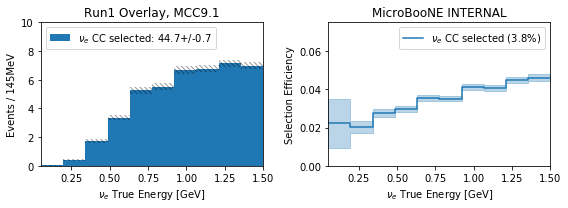

<IPython.core.display.Javascript object>

In [29]:
print(
    "selected nue per {:.3g}POT: {:.1f}".format(
        tot_pot, sum(df_nu_event["nu_mu_cc_selected"]) / scale_pot
    )
)
nue_pass_mask = df_nu_event["nu_mu_cc_selected"] & nu_sig_mask
num_nue_pass = sum(df_nu_event["event_weight"][nue_pass_mask])
num_nue_pass_err = np.sqrt(num_nue_pass)
print(
    "Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: {0:.2f}+/-{1:.2f} per {2:.3g}POT.".format(
        num_nue_pass / scale_pot, num_nue_pass_err / scale_pot, tot_pot
    )
)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3), sharex=True)

N = 10
x_min = 0.05
x_max = 1.5


E_all = nue["events"].array("mc_nu_energy")[nu_sig_mask]
pass_mask = nu_sig_mask & nue["events"].array("nu_mu_cc_selected")
E_sel = nue["events"].array("mc_nu_energy")[pass_mask]

edges, edges_mid, bins, err, max_val = helper.histHelper(
    N, x_min, x_max, [E_sel, E_all], weights=[1 / scale_pot] * 2
)

widths = edges[1:] - edges[:-1]
ax[0].bar(
    edges_mid,
    bins[0],
    lw=2,
    width=widths,
    label=r"$\nu_e$ CC selected: {0:.1f}+/-{1:.1f}".format(
        num_nue_pass / scale_pot, num_nue_pass_err / scale_pot
    ),
)
for m, v, e, w in zip(edges_mid, bins[0], err[0], widths):
    ax[0].add_patch(
        patches.Rectangle(
            (m - w / 2, v - e),
            w,
            2 * e,
            hatch="\\\\\\\\\\",
            Fill=False,
            linewidth=0,
            alpha=0.4,
        )
    )
ax[0].set_xlabel(r"$\nu_e$ True Energy [GeV]")
ax[0].set_ylabel(r"Events / 145MeV")
ax[0].set_ylim(0, 10)
ax[0].legend(loc="upper left")
ax[0].set_title("Run1 Overlay, MCC9.1")


_, _, bins, _, _ = helper.histHelper(N, x_min, x_max, [E_sel, E_all])
fraq = bins[0] / bins[1]
ratio = sum(bins[0]) / sum(bins[1])
err = np.sqrt(fraq * (1 - fraq) / bins[1])
fraq = np.append(fraq, fraq[-1])
err = np.append(err, err[-1])

ax[1].step(
    edges,
    fraq,
    where="post",
    label=r"$\nu_e$ CC selected ({0:.1f}%)".format(ratio * 100),
)
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post", color="C0")
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylabel(r"Selection Efficiency")
ax[1].set_xlabel(r"$\nu_e$ True Energy [GeV]")
ax[1].set_ylim(0, 0.075)
ax[1].set_title("MicroBooNE INTERNAL")
ax[1].legend()

fig.tight_layout()
fig.savefig(outdir + "unblinding_nue_E.pdf")